# Random Forest - Poisonous Mushroom Classifier

Have you ever picked up wild mushroom and wondered whether it was edible or not? We are given a dataset of purely categorical features and want to create a model to classify whether a mushroom with specific traits is edible or poisonous. 
The data guide states that there is no simple rule to determine whether a mushroom is poisonous or not. This is why an ML model would be beneficial.

# 0. Import Libraries and Dataset

In [1]:
import numpy as np
import pandas as pd

from scipy.stats import chi2_contingency

from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

import os

data_path = '../input/mushroom-classification/mushrooms.csv'
mushroom_data = pd.read_csv(data_path)

# 1. Exploratory Data Analysis

We can start by taking a peak at the dataset and how it is formatted.

In [2]:
mushroom_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                8124 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

In [3]:
mushroom_data.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [4]:
# Shape of the dataset
print("We have", mushroom_data.shape[1], "features with", mushroom_data.shape[0], "observations")

mushroom_data.describe().T

We have 23 features with 8124 observations


,count,unique,top,freq
class,8124,2,e,4208
cap-shape,8124,6,x,3656
cap-surface,8124,4,y,3244
cap-color,8124,10,n,2284
bruises,8124,2,f,4748
odor,8124,9,n,3528
gill-attachment,8124,2,f,7914
gill-spacing,8124,2,c,6812
gill-size,8124,2,b,5612
gill-color,8124,12,b,1728


In [5]:
# Number of missing data values
print("The dataset has", mushroom_data.isnull().sum().sum(), "missing points.")

mushroom_data.isnull().sum()

The dataset has 0 missing points.


class                       0
cap-shape                   0
cap-surface                 0
cap-color                   0
bruises                     0
odor                        0
gill-attachment             0
gill-spacing                0
gill-size                   0
gill-color                  0
stalk-shape                 0
stalk-root                  0
stalk-surface-above-ring    0
stalk-surface-below-ring    0
stalk-color-above-ring      0
stalk-color-below-ring      0
veil-type                   0
veil-color                  0
ring-number                 0
ring-type                   0
spore-print-color           0
population                  0
habitat                     0
dtype: int64

In [6]:
# object_columns = [col for col in mushroom_data.columns if mushroom_data[col].dtype==object]
mushroom_data.dtypes

class                       object
cap-shape                   object
cap-surface                 object
cap-color                   object
bruises                     object
odor                        object
gill-attachment             object
gill-spacing                object
gill-size                   object
gill-color                  object
stalk-shape                 object
stalk-root                  object
stalk-surface-above-ring    object
stalk-surface-below-ring    object
stalk-color-above-ring      object
stalk-color-below-ring      object
veil-type                   object
veil-color                  object
ring-number                 object
ring-type                   object
spore-print-color           object
population                  object
habitat                     object
dtype: object

Text(0.5, 1.0, 'Edible vs Poisonous Mushrooms in Dataset')

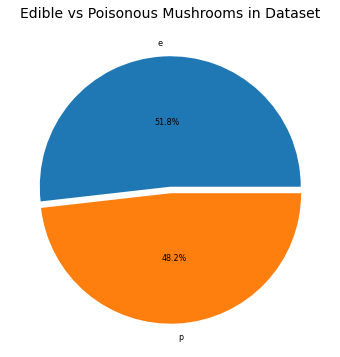

In [7]:
class_data = mushroom_data['class'].value_counts()
pie, ax = plt.subplots(figsize=[10,6])
labels = class_data.keys()
plt.pie(x=class_data, autopct="%.1f%%",explode=[0,0.05], labels=labels, pctdistance=0.5)
plt.title("Edible vs Poisonous Mushrooms in Dataset", fontsize=14)

### Summary

We have 8124 observations with 23 features. One of the features will be used for our target variable (class). All our features are object types and are not missing any data points.

### Initial Thoughts

Since we have a relatively small dataset here, I am thinking of one-hot encoding all the features. If we did have missing values, I would experiment with removing rows or imputing and how that would affect the model.
I also noticed that there a feature that has one value for all 8124 observations (veil-type). I will probably end up dropping that column from the dataset.

# 2. Feature Engineering and Selection

Because all of our features are categorical along with our target variable, we have two main tests for feature importance

1. Chi-squared test
2. Mutual Information

### One-Hot Encoding (getting data ready for analysis)

In [8]:
# Copy the original data
X = mushroom_data.copy()
y = X.pop('class')

# Remove useless feature
X = X.drop('veil-type', axis=1)

X = pd.get_dummies(X)
y = pd.factorize(y)

X.head()

,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,cap-surface_f,cap-surface_g,cap-surface_s,cap-surface_y,...,population_s,population_v,population_y,habitat_d,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w
0,0,0,0,0,0,1,0,0,1,0,...,1,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,1,0,0,0,1,...,1,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0


### What is the Chi-squared test for feature selection?

The Chi-squared test for independence is for testing whether two variables are independent from each other. When working with categorical data, the chi-square test is often used to minimize the noise in the input when building the model. 

\begin{gather*}
H_0 = \text{The relationship is independent}\\
H_1 = \text{The relationship is not independent}
\end{gather*}

The p-value we will use as our threshold is 0.05. That means we are looking at a 95% confidence interval. However one thing to note is that we are one-hot encoding the features before running the chi-squared tests. Since we are doing it this way, 
the p-value that we are going to use to reject the null hypothesis is going to be different depending on the feature's number of unique instances. The p-value we will actually use will be determined by the following formula:

\begin{gather*}
\text{p-value} = \frac{0.05}{\text{# of unique indexes}}
\end{gather*}

In [9]:
X_temp = mushroom_data.copy().drop('class', axis=1).drop('veil-type', axis=1)
# Find the p values from the chi2 test for each column
chi2_scores = []
chi2_pvalues = []
features_to_drop = []
for i in X_temp.columns:
    dummies = pd.get_dummies(X_temp[i])
    for j in dummies:
        chi_score = chi2_contingency(pd.crosstab(y[0],dummies[j]))[0]
        p_value = chi2_contingency(pd.crosstab(y[0],dummies[j]))[1]*X_temp[i].nunique()
        chi2_scores.append(chi_score)
        chi2_pvalues.append(p_value)
        if p_value > 0.05:
            features_to_drop.append(i+'_'+j)
chi2_scores = pd.Series(chi2_scores, index=X.columns).sort_values(ascending=False)
chi2_scores

odor_n                        5010.142672
odor_f                        3158.863210
stalk-surface-above-ring_k    2802.974198
stalk-surface-below-ring_k    2669.679820
ring-type_p                   2370.911030
                                 ...     
cap-shape_f                      2.712653
stalk-root_b                     2.477984
cap-surface_g                    2.475240
cap-shape_c                      2.475240
stalk-surface-above-ring_y       1.576158
Length: 116, dtype: float64

Text(0.5, 1.0, 'Chi-Squared Scores of Features')

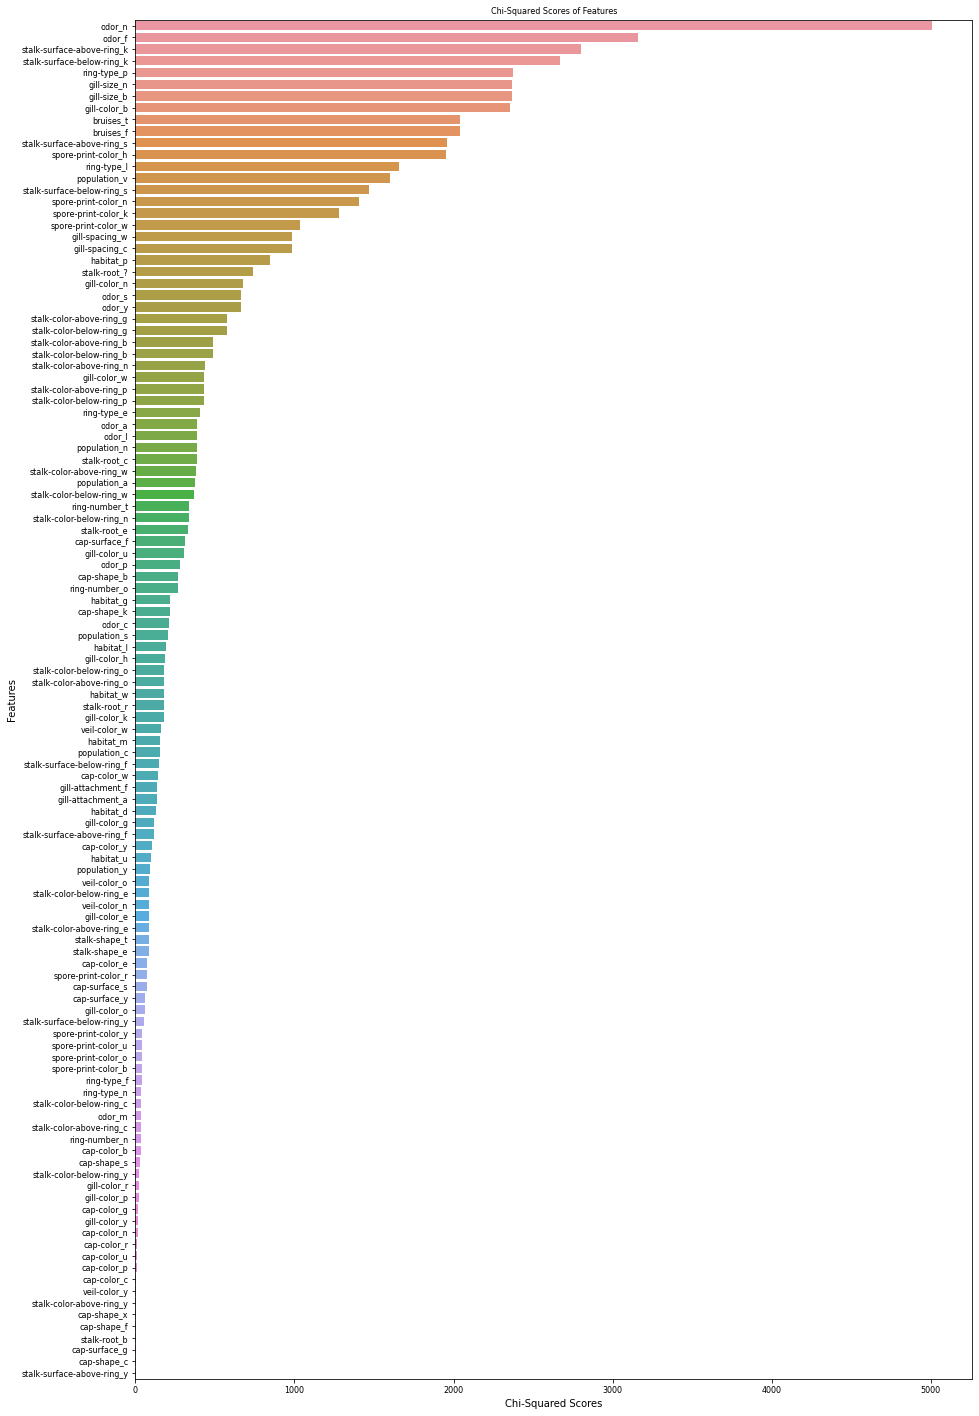

In [10]:
# Plot the Chi2 scores
fig, ax = plt.subplots(figsize=(15,25))

sns.barplot(x = chi2_scores, y=chi2_scores.index)

ax.set_xlabel('Chi-Squared Scores')
ax.set_ylabel('Features')
ax.set_title('Chi-Squared Scores of Features')

In [11]:
# These are the features that failed to reject the null hypothesis (p-value>0.05)
features_to_drop

['cap-shape_c',
 'cap-shape_f',
 'cap-shape_x',
 'cap-surface_g',
 'cap-color_c',
 'stalk-root_b',
 'stalk-surface-above-ring_y',
 'stalk-color-above-ring_y']

In [12]:
# Dropping failed features
X_chi2 = X.drop(features_to_drop, axis=1)
X_chi2.head()

,cap-shape_b,cap-shape_k,cap-shape_s,cap-surface_f,cap-surface_s,cap-surface_y,cap-color_b,cap-color_e,cap-color_g,cap-color_n,...,population_s,population_v,population_y,habitat_d,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w
0,0,0,0,0,1,0,0,0,0,1,...,1,0,0,0,0,0,0,0,1,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
4,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0


### Mutual Information method of Feature Selection

Mutual Information measures the non-linear relationship between two variables. We will be calculating a score for mutual information and build a model with the selected features.

In [13]:
# Mutual Information
mi_scores = mutual_info_classif(X, y[0])
mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
mi_scores = mi_scores.sort_values(ascending=False)
mi_scores

odor_n                        0.361551
odor_f                        0.251299
stalk-surface-above-ring_k    0.191785
stalk-surface-below-ring_k    0.189246
gill-color_b                  0.179211
                                ...   
cap-shape_x                   0.000000
cap-color_p                   0.000000
ring-type_f                   0.000000
cap-color_c                   0.000000
stalk-root_b                  0.000000
Name: MI Scores, Length: 116, dtype: float64

Text(0.5, 1.0, 'MI Score')

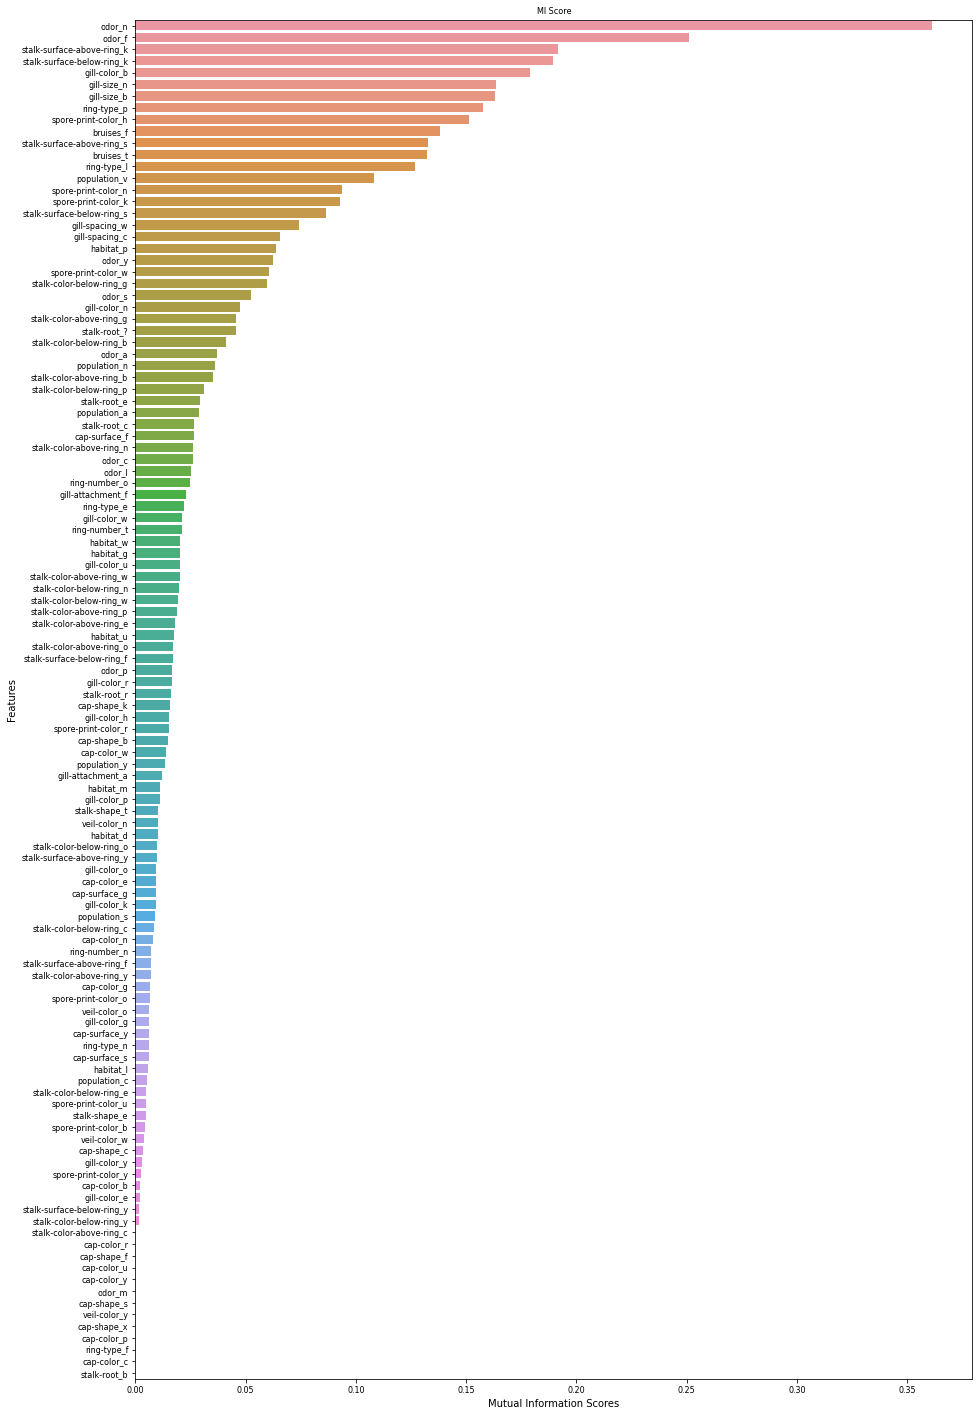

In [14]:
# Plot the Chi2 scores
fig, ax = plt.subplots(figsize=(15,25))

sns.barplot(x = mi_scores, y=mi_scores.index)

ax.set_xlabel('Mutual Information Scores')
ax.set_ylabel('Features')
ax.set_title('MI Score')

In [15]:
# Lets find redundant and non-relevant features
duplicates = mi_scores.duplicated()

bad_features = [x for x in duplicates.index if (duplicates[x]==True)]
bad_features

['cap-color_r',
 'cap-shape_f',
 'cap-color_u',
 'cap-color_y',
 'odor_m',
 'cap-shape_s',
 'veil-color_y',
 'cap-shape_x',
 'cap-color_p',
 'ring-type_f',
 'cap-color_c',
 'stalk-root_b']

In [16]:
X_mi = X.drop(bad_features, axis=1)
X_mi.head()

,cap-shape_b,cap-shape_c,cap-shape_k,cap-surface_f,cap-surface_g,cap-surface_s,cap-surface_y,cap-color_b,cap-color_e,cap-color_g,...,population_s,population_v,population_y,habitat_d,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w
0,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0


In [17]:
# Common dropped features from Chi2 test and MI test
common_bad_features = set(features_to_drop) & set(bad_features)
common_bad_features

{'cap-color_c', 'cap-shape_f', 'cap-shape_x', 'stalk-root_b'}

### Summary

Of the dropped features between the two modified input data, we had 4 common features. 

One thing I did not consider for the mutual information test was testing for interaction variables. Just because the features were not correlated to the target variable does not mean they can have some relationship with the other features. 

# 3. Model Building

The algorithm we will use for modeling is Random Forest. To increase robustness of the model, I will perform cross validation to get a mean accuracy between 5 folds of training and testing data. Also, all feature selection data sets will be tested, and the performance will be compared.

### Baseline Model

In [18]:
# Separate training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y[0], test_size=0.25, random_state=0)

# Baseline Random Forest with default parameters
model = RandomForestClassifier(random_state=0)
fit = model.fit(X_train, y_train)
predictions = fit.predict(X_test)
print(classification_report(predictions, y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       970
           1       1.00      1.00      1.00      1061

    accuracy                           1.00      2031
   macro avg       1.00      1.00      1.00      2031
weighted avg       1.00      1.00      1.00      2031



Interestingly enough, we got an accuracy of 100% which does not seem very reasonable. I will conduct a 5 fold CV on the default model to get a more robust accuracy.

In [19]:
# 5 fold CV of default Random Forest model
score = cross_val_score(
    model, X, y[0], cv=5, scoring='accuracy'
)
print('Average accuracy of base model: ', score.mean())

Average accuracy of base model:  0.9257583175445244


In [20]:
# Separate training and testing data for the chi2 features
Xchi_train, Xchi_test, y_train, y_test = train_test_split(X_chi2, y[0], test_size=0.25, random_state=0)

# Chi 2 features model
fit_chi = model.fit(Xchi_train, y_train)
predictions_chi = fit_chi.predict(Xchi_test)
print(classification_report(predictions_chi, y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       970
           1       1.00      1.00      1.00      1061

    accuracy                           1.00      2031
   macro avg       1.00      1.00      1.00      2031
weighted avg       1.00      1.00      1.00      2031



Again, we have a 100% accuracy but for the chi2 model. Lets try 5-fold CV.

In [21]:
# 5 fold CV of Chi2 Random Forest model
score = cross_val_score(
    model, X_chi2, y[0], cv=5, scoring='accuracy'
)
print('Average accuracy of chi2 model: ', score.mean())

Average accuracy of chi2 model:  0.9173839333080712


In [22]:
# 5 fold CV of MI Random Forest model
score = cross_val_score(
    model, X_mi, y[0], cv=5, scoring='accuracy'
)
print('Average accuracy of MI model: ', score.mean())

Average accuracy of MI model:  0.9276056081849186


With default parameters for the model, we have a slight improvement in accuracy for the MI input data, while a slight decrease in accuracy for the Chi2 input.

Let's try them with 50 trees now in the random forest.

In [23]:
model_50 = RandomForestClassifier(n_estimators=50, random_state=0)

# 5 fold CV of default Random Forest model
score = cross_val_score(
    model_50, X, y[0], cv=5, scoring='accuracy'
)
print('Average accuracy of base model (50 trees):', score.mean())

# 5 fold CV of Chi2 Random Forest model
score = cross_val_score(
    model_50, X_chi2, y[0], cv=5, scoring='accuracy'
)
print('Average accuracy of chi2 model (50 trees):', score.mean())

# 5 fold CV of MI Random Forest model
score = cross_val_score(
    model_50, X_mi, y[0], cv=5, scoring='accuracy'
)
print('Average accuracy of MI model (50 trees):', score.mean())

Average accuracy of base model (50 trees): 0.9332706328154604
Average accuracy of chi2 model (50 trees): 0.9219405835543768
Average accuracy of MI model (50 trees): 0.9345021599090565


Even with a random forest with 50 trees, our MI model still comes out on top with the Chi2 on the bottom again.

Lets try to optimize the n_estimators parameter such that we are not under nor over fitting the data.

In [24]:
n_estimators = [10,20,30,40,50,60,70,80,90,100]
mean_scores = []
for i in n_estimators:
    model = RandomForestClassifier(n_estimators=i, random_state=0)
    score = cross_val_score(
    model, X_mi, y[0], cv=5, scoring='accuracy'
    )
    mean_scores.append(score.mean())
    print('Average accuracy of MI model (',i,'trees):', score.mean())

Average accuracy of MI model ( 10 trees): 0.8883198938992043
Average accuracy of MI model ( 20 trees): 0.9145514209928003
Average accuracy of MI model ( 30 trees): 0.9236647214854111
Average accuracy of MI model ( 40 trees): 0.936226297840091
Average accuracy of MI model ( 50 trees): 0.9345021599090565
Average accuracy of MI model ( 60 trees): 0.9301918150814703
Average accuracy of MI model ( 70 trees): 0.9348716180371353
Average accuracy of MI model ( 80 trees): 0.9273593027661994
Average accuracy of MI model ( 90 trees): 0.9283445244410762
Average accuracy of MI model ( 100 trees): 0.9276056081849186


Text(0.5, 1.0, 'Accuracy of different n_estimators (5 fold CV)')

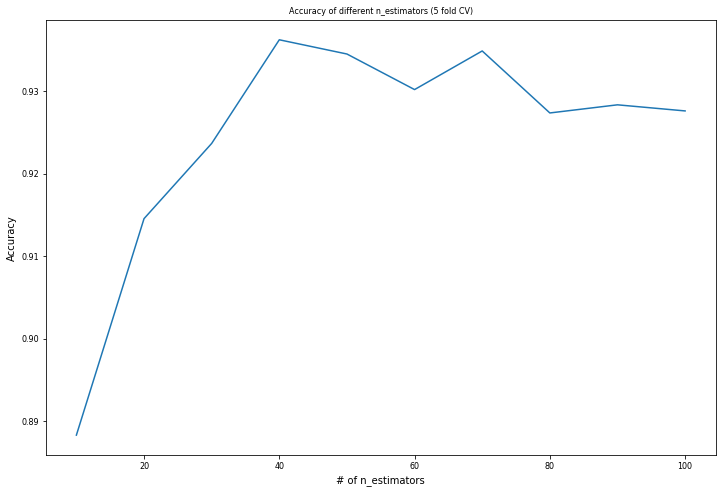

In [25]:
mean_scores = pd.Series(mean_scores, index=n_estimators)

# Plot the CV scores
fig, ax = plt.subplots(figsize=(12,8))

sns.lineplot(x = mean_scores.index, y=mean_scores)

ax.set_ylabel('Accuracy')
ax.set_xlabel('# of n_estimators')
ax.set_title('Accuracy of different n_estimators (5 fold CV)')

We got an optimal number of estimators of 50. Now compare the accuracy with different k-folds.

Text(0.5, 1.0, 'Accuracy vs number of k-folds')

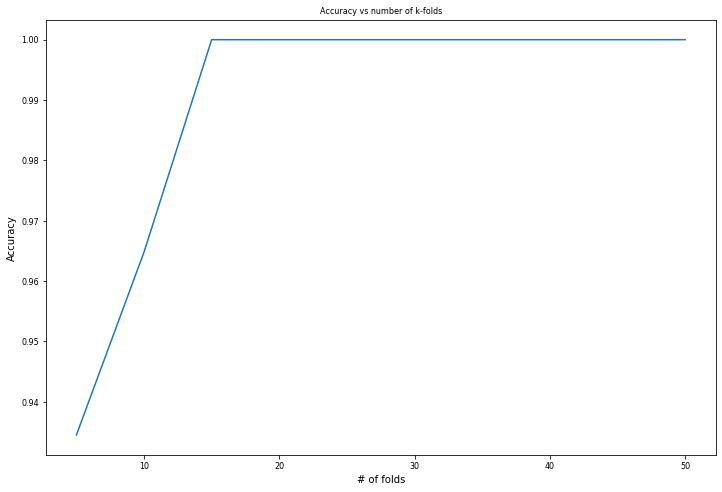

In [26]:
# MI model CV with different k-folds
accuracies = []
model = RandomForestClassifier(n_estimators=50, random_state=0)
for i in range(5,55,5):
    score = cross_val_score(
    model, X_mi, y[0], cv=i, scoring='accuracy'
    )
    accuracies.append(score.mean())
    
accuracies = pd.Series(accuracies, index=np.arange(5,55,5))

# Plot the CV scores
fig, ax = plt.subplots(figsize=(12,8))

sns.lineplot(x = accuracies.index, y=accuracies)

ax.set_ylabel('Accuracy')
ax.set_xlabel('# of folds')
ax.set_title('Accuracy vs number of k-folds')

# Conclusion

Building a model based on the features selected from Mutual information resulted in the best performance compared to Chi-squared and default. Also, one thing I realize is that I split the training and testing data after modifying the data. Normally I would split the data first, but since I did not really alter any values (imputation), I do not think it would make a difference.


# Question for the Community

I'm under the impression that "leave one out" cross validation is preferred for smaller datasets, however I am getting a 100% accuracy on anything past 25 fold CV. Is this a case of overfitting, or is it just the dataset?